In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

In [3]:
os.path.exists('chat2.txt')

True

In [4]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%m/%d/%y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r',encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        #print(date_time)
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        #print(df.user_msg)
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [5]:
df=rawToDf('chat2.txt','12hr')

In [6]:
df.user

0           grp_notif
1           grp_notif
2           grp_notif
3           grp_notif
4           grp_notif
            ...      
2702    Hostel Prince
2703    Hostel Prince
2704    Hostel Prince
2705    Hostel Prince
2706     Pragati Tjit
Name: user, Length: 2707, dtype: object

In [7]:
images=df[df['msg']=='<Media omitted> '] #no.of images , images  are present in <Media omitted>format
images.shape[0]

876

In [8]:
df.head()

,date_time,user,msg
0,2019-05-18 07:46:00,grp_notif,Messages and calls are end-to-end encrypted. N...
1,2017-10-18 14:54:00,grp_notif,"Av created group ""Haan sunao👂🏻 na💁🏻‍♂"""
2,2019-05-18 07:46:00,grp_notif,Rahul Gupta Watsup added you
3,2019-05-18 07:46:00,grp_notif,You're now an admin
4,2019-05-18 17:28:00,grp_notif,Av left


In [9]:
me='Arun Vinodia'

In [10]:
df['user'].unique()

array(['grp_notif', 'Arun Vinodia', 'Rahul Gupta Watsup', 'Ankit',
       'Sharma Tjit', 'Alok', 'Imran', '+91 88048 19663', 'Gopal',
       'Choubrainn', 'Hostel Prince', 'Pragati Tjit'], dtype=object)

In [11]:
grp_notif=df[df['user']=='grp_notif']
grp_notif.shape

(41, 3)

In [12]:
#removing images 
df.drop(images.index,inplace=True)
df.drop(grp_notif.index,inplace=True)

In [13]:
df.tail()

,date_time,user,msg
2701,2020-12-22 17:18:00,Ankit,South ka villain lag rha hai 😂
2702,2020-12-22 17:18:00,Hostel Prince,Hmm
2704,2020-12-22 17:20:00,Hostel Prince,IPS SINGHAM
2705,2020-12-22 17:20:00,Hostel Prince,Next garuda for sure
2706,2020-12-22 18:27:00,Pragati Tjit,😂😂😂


In [14]:
df.reset_index(inplace=True, drop=True)
df.shape

(1790, 3)

In [15]:
df.user.unique()

array(['Arun Vinodia', 'Rahul Gupta Watsup', 'Ankit', 'Sharma Tjit',
       'Alok', 'Imran', '+91 88048 19663', 'Gopal', 'Choubrainn',
       'Hostel Prince', 'Pragati Tjit'], dtype=object)

### Lets Discuss on what do we want to get out of this data

##### * Is raw data enough to get that insight?
##### * If not what can be possible way to get that insight?
##### * Whats the use of that insight?

#### Q1> Who is the most active member of the group, who is the least active?

In [16]:
#Most active member of the group

df.groupby('user')['msg'].count().sort_values(ascending=False)

user
Sharma Tjit           391
Rahul Gupta Watsup    366
Arun Vinodia          276
Pragati Tjit          227
Ankit                 184
Hostel Prince         141
Imran                  69
Gopal                  49
+91 88048 19663        41
Choubrainn             34
Alok                   12
Name: msg, dtype: int64

In [17]:
#count the number of emoji used:

emoji_ctr= Counter()
emojis_list= map(lambda x:' '.join(x.split()),emoji.UNICODE_EMOJI.keys())
r= re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row['user']=='Pragati Tjit':
        emojis_found=r.findall(row['msg'])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found]+=1

In [18]:
for item in emoji_ctr.most_common(5):
    print(item[0]+' - '+str(item[1]))

😂 - 131
😅 - 47
☺ - 35
😒 - 14
🏻 - 4


<AxesSubplot:xlabel='hour'>

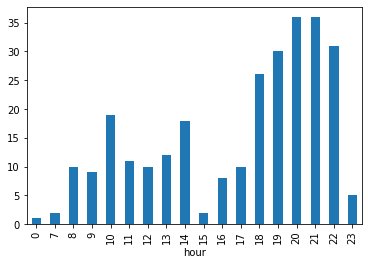

In [19]:
df['hour']=df['date_time'].apply(lambda x:x.hour)
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x='hour',kind='bar')

In [20]:
# weekend vs weekdays usage pattern

df['weekday']=df['date_time'].apply(lambda x:x.day_name())

In [21]:
df['is_weekend']=df.weekday.isin(['Sunday','Saturday'])

In [22]:
msgs_per_user= df['user'].value_counts(sort=True)
msgs_per_user

Sharma Tjit           391
Rahul Gupta Watsup    366
Arun Vinodia          276
Pragati Tjit          227
Ankit                 184
Hostel Prince         141
Imran                  69
Gopal                  49
+91 88048 19663        41
Choubrainn             34
Alok                   12
Name: user, dtype: int64

In [23]:
top5users= msgs_per_user.index.tolist()[:5]
top5users

['Sharma Tjit', 'Rahul Gupta Watsup', 'Arun Vinodia', 'Pragati Tjit', 'Ankit']

In [53]:
df_top5=df.copy()

In [54]:
df_top5= df_top5[df_top5.user.isin(top5users)]
df_top5.head()

,date_time,user,msg,hour,weekday,is_weekend
0,2019-05-20 19:54:00,Arun Vinodia,😁😁😁,19,Monday,False
1,2019-05-22 20:56:00,Rahul Gupta Watsup,Shootout in hebbal,20,Wednesday,False
2,2019-05-27 12:51:00,Arun Vinodia,https://youtu.be/oekSvnsMa1A,12,Monday,False
3,2019-05-27 12:51:00,Arun Vinodia,Ankit tis song is for u!,12,Monday,False
4,2019-05-27 12:51:00,Arun Vinodia,😁,12,Monday,False


<AxesSubplot:xlabel='user', ylabel='count'>

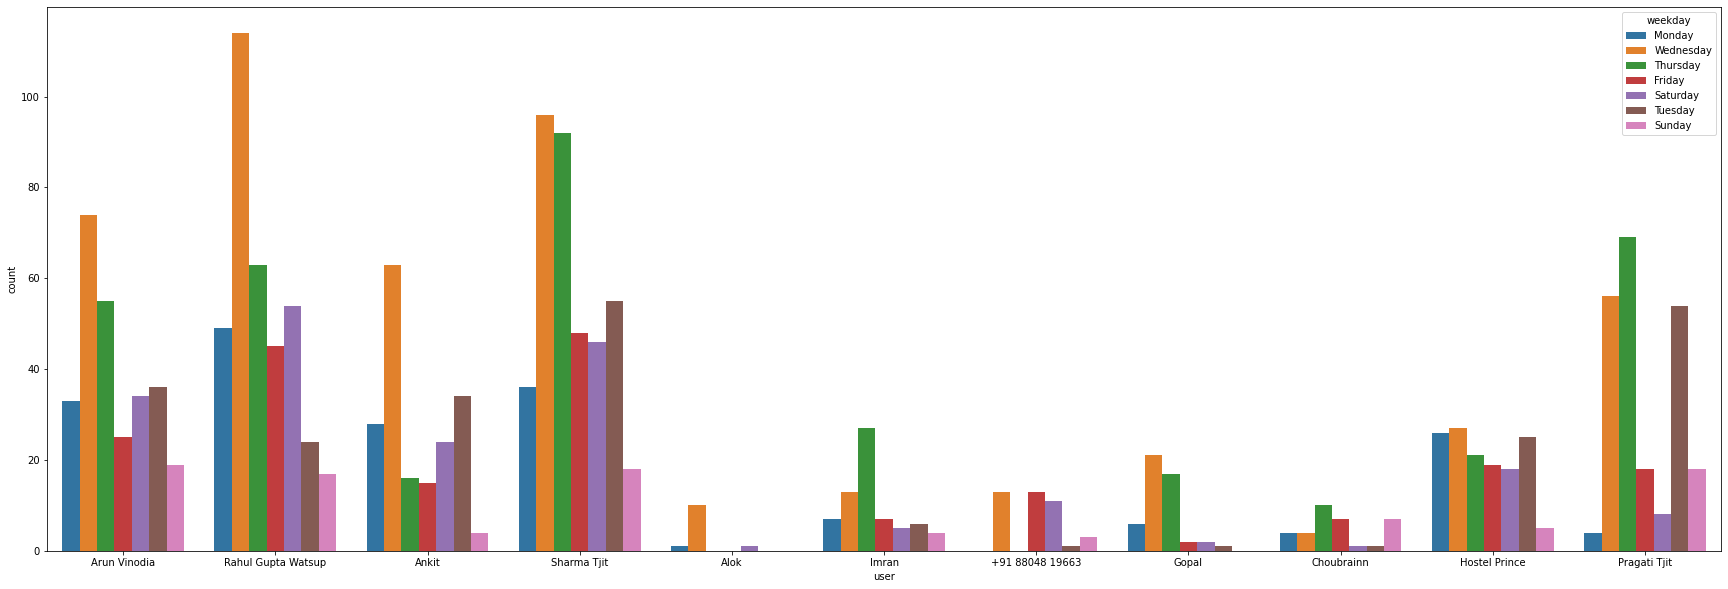

In [60]:
plt.figure(figsize=(30,10))
sns.countplot(x='user',hue='weekday',data=df)

<AxesSubplot:xlabel='user', ylabel='count'>

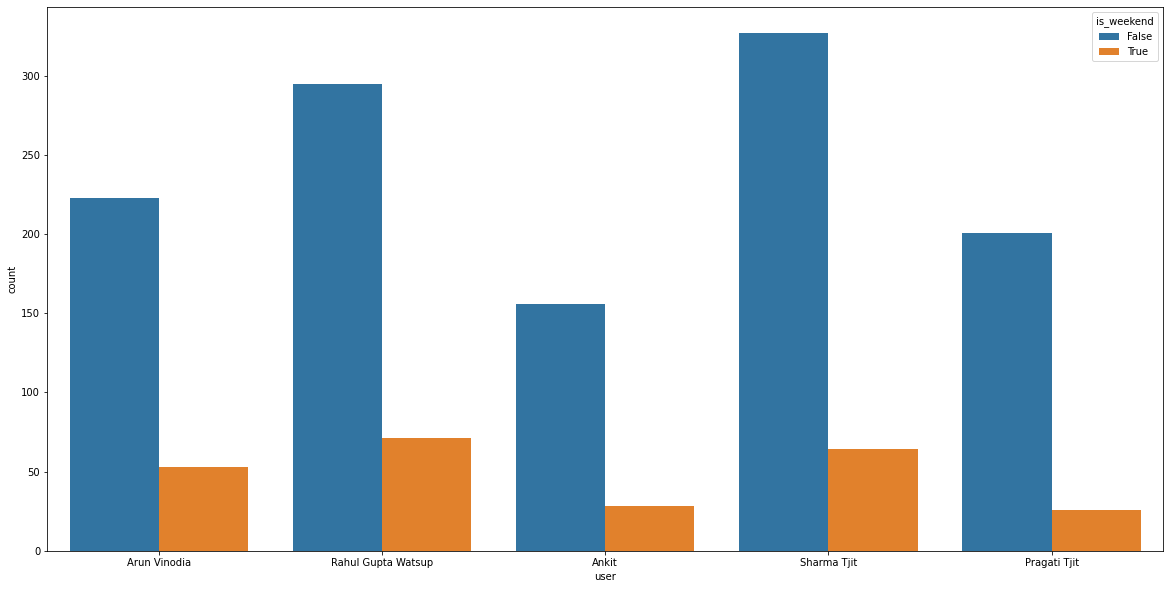

In [61]:
plt.figure(figsize=(20,10))
sns.countplot(x='user',hue='is_weekend',data=df_top5)

In [62]:
def word_count(val):
    return len(val.split())

In [63]:
df['no_of_words']=df['msg'].apply(word_count)

In [64]:
df_top5['no_of_words']=df_top5['msg'].apply(word_count)


In [66]:
total_words_weekday= df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

8651

In [69]:
total_words_weekday/5 #average words on a weekday

1730.2

In [70]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Sharma Tjit           3150
Pragati Tjit          1598
Rahul Gupta Watsup    1418
Ankit                 1188
Arun Vinodia          1085
Hostel Prince          696
Imran                  334
Gopal                  205
+91 88048 19663        176
Choubrainn             151
Alok                    63
Name: no_of_words, dtype: int64

In [71]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Sharma Tjit           8.056266
Pragati Tjit          7.039648
Ankit                 6.456522
Arun Vinodia          3.931159
Rahul Gupta Watsup    3.874317
dtype: float64

In [72]:
wordPerMsg_weekday_vs_weekend= (df_top5.groupby(['user','is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user','is_weekend']).size())

In [73]:
wordPerMsg_weekday_vs_weekend

user                is_weekend
Ankit               False         6.371795
                    True          6.928571
Arun Vinodia        False         3.950673
                    True          3.849057
Pragati Tjit        False         7.502488
                    True          3.461538
Rahul Gupta Watsup  False         3.759322
                    True          4.352113
Sharma Tjit         False         8.425076
                    True          6.171875
dtype: float64

<AxesSubplot:ylabel='user,is_weekend'>

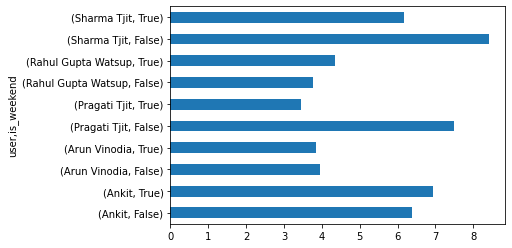

In [74]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

In [55]:
comment_words=' '
stopwords=STOPWORDS.update(['And','also','the','What','ð','upload','teams-microsoft','https','3/4','a`','hai'])

for val in df.msg.values:
    val=str(val)
    tokens=val.split()
    
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    for words in tokens:
        comment_words=comment_words+words+' '

wordcloud = WordCloud(width=600,height=400,
                     background_color='black',
                     stopwords=stopwords,
                     min_font_size=10).generate(comment_words)

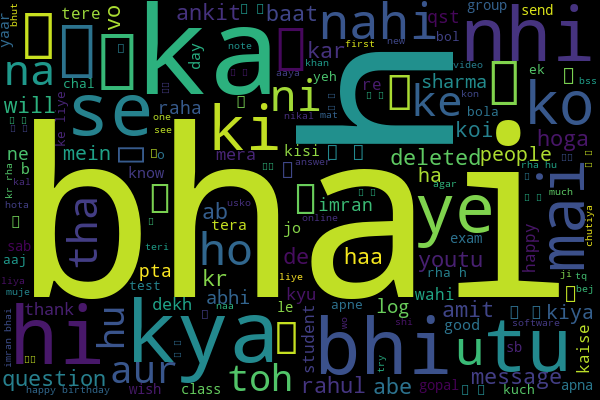

In [56]:
wordcloud.to_image()

In [57]:
comment_words=' '
stopwords=STOPWORDS.update(['And','also','the','What','ð','h','tha','upload','teams-microsoft','https','3/4','a`','hai','n','ka','u'])

for val in df[df['user']=='Rahul Gupta Watsup'].msg.values:
    val=str(val)
    tokens=val.split()
    
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    for words in tokens:
        comment_words=comment_words+words+' '

wordcloud = WordCloud(width=600,height=400,
                     background_color='black',
                     stopwords=stopwords,
                     min_font_size=10).generate(comment_words)

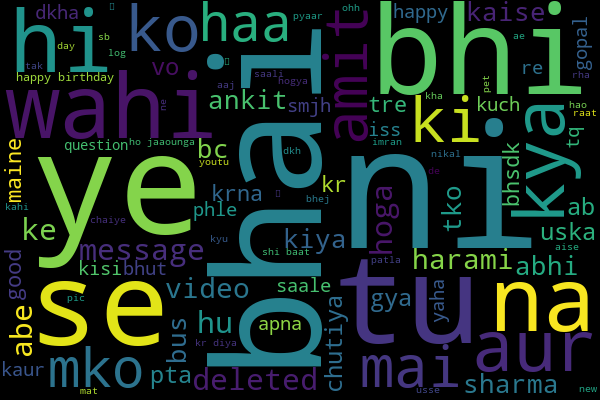

In [58]:
wordcloud.to_image()